In [42]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import pandas as pd
import seaborn as sns

import particle_filter as pf
from proj_data import proj_data
from lotvol_model import LotVolModel

key = random.PRNGKey(0)

# parameter values

alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.01
sigma_l = 0.01
tau_h = 0.25
tau_l = 0.25

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.01
n_res = 2
n_obs = 100
lotvol_model = LotVolModel(dt, n_res) 
key, subkey = random.split(key)


In [43]:
x_init = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                     theta=jnp.append(theta[0:6], jnp.array([0., 0.])),
                     key=subkey)

In [44]:
x_init

DeviceArray([[1.609438 , 1.0986123],
             [1.5992675, 1.102173 ]], dtype=float32)

In [45]:
y_meas, x_state = pf.meas_sim(lotvol_model, n_obs, x_init, theta, subkey)


In [46]:
x_state.shape

(100, 2, 2)

Text(0.5, 1.0, 'Observations')

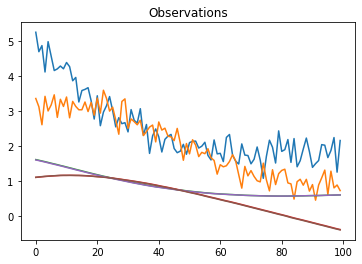

In [54]:
import matplotlib.pyplot as plt
plt.plot(y_meas[:, 0])
plt.plot(y_meas[:, 1])
plt.plot(x_state[:,0])
plt.plot(x_state[:, 1])
plt.title("Observations and Latent")

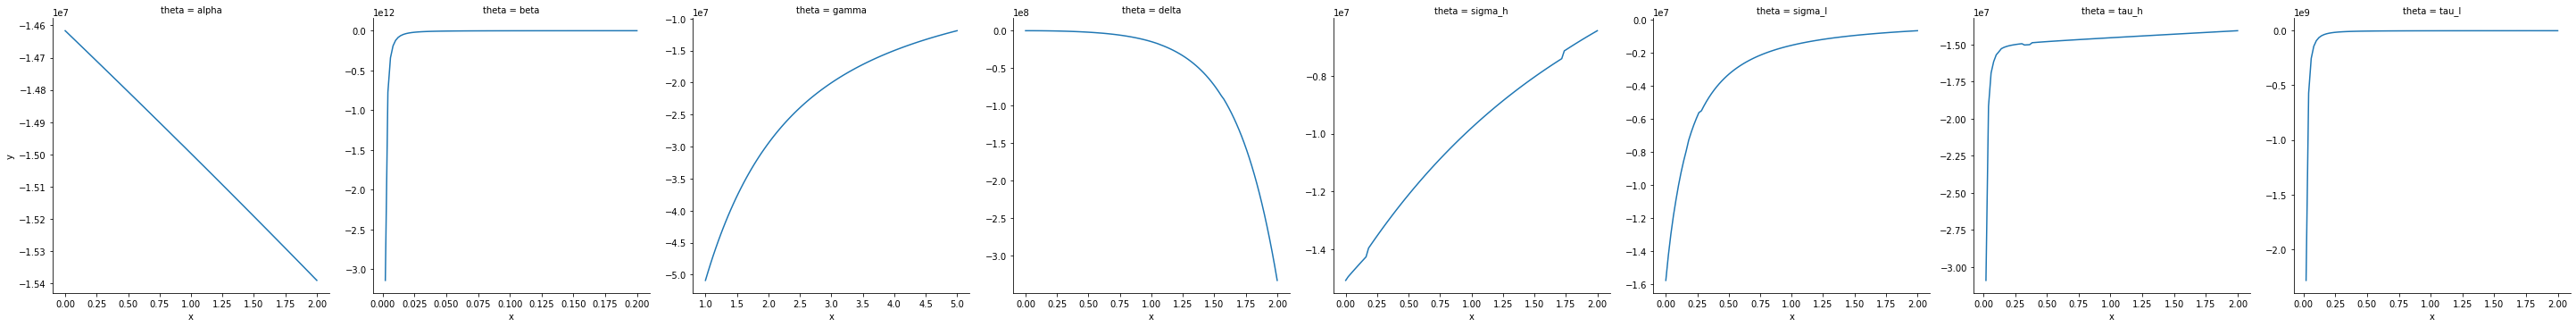

In [50]:
theta_lims = np.array([[0., 2.], [0., .2], [1.0, 5.0], [0., 2.], [0., 2.], [0., 2.], [0., 2.], [0., 2.]])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot

def custom_fn(th):
    temp = pf.particle_filter(lotvol_model, y_meas, th, 100, key)
    return pf.particle_loglik(temp['logw_particles'])

plot_df = proj_data(lambda th: custom_fn(th),
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    facet_kws=dict(sharex=False, sharey=False)
)

Stochastic Optimization given below

In [48]:
from particle_filter import stoch_opt, get_sum_lweights

In [49]:
stoch_opt(lotvol_model, jnp.array([1.,1.,4., 1., 0.01, 0.01, 0.25, 0.25]), get_sum_lweights, y_meas, key=key, learning_rate=0.0000000001, iterations=2000, n_particles=1000,
         mask=np.array([0,1,0,0,0,0,0,0]))

/home/pranavsubramani/.local/lib/python3.8/site-packages/jax/interpreters/xla.py:841: UserWarning: Some donated buffers were not usable: f32[8]{0}
  warn("Some donated buffers were not usable: {}".format(


[1.        1.0026327 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.0052265 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.0077888 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.0103574 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.0129044 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.0154463 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.0179185 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.0203868 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.0228428 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.0252895 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.0277346 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.0301536 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.0325519 4.        1.        0.01      0.01      0.2

[1.        1.2180176 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.2194963 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.2209748 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.222446 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        1.2239251 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.2253911 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.2268562 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.2283134 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.229775 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        1.2312198 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.2326674 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.234101 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        1.2355261 4.        1.        0.01      0.01      0.25
 0.25     

[1.        1.3604294 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.3615131 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.3625834 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.3636738 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.3647519 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.3658304 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.3669077 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.3679758 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.3690425 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.370114 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        1.3711703 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.3722231 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.3732759 4.        1.        0.01      0.01      0.25
 0

[1.        1.4688777 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.469747 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        1.4706165 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.4714805 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.4723355 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.4731953 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.4740623 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.4749255 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.4757853 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.4766502 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.4775124 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.4783679 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.4792212 4.        1.        0.01      0.01      0.25
 0

[1.        1.5590858 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.559826 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        1.5605599 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.5612962 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.5620166 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.562755 4.       1.       0.01     0.01     0.25     0.25    ]
[1.       1.563489 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        1.5642174 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.5649415 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.5656712 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.5663981 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.5671234 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.5678476 4.        1.        0.01      0.01      0.25
 0.25     

[1.        1.6373135 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.6379565 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.6385942 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.639225 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        1.6398698 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.640509 4.       1.       0.01     0.01     0.25     0.25    ]
[1.       1.641145 4.       1.       0.01     0.01     0.25     0.25    ]
[1.      1.64178 4.      1.      0.01    0.01    0.25    0.25   ]
[1.       1.642417 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        1.6430513 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.6436799 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.6443098 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.644938 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        1.64556

[1.        1.7049794 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7055544 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7061211 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7066925 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7072624 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7078304 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7084054 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7089734 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7095354 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7101012 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.710659 4.       1.       0.01     0.01     0.25     0.25    ]
[1.       1.711225 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        1.7117953 4.        1.        0.01      0.01      0.25
 0.25 

[1.        1.7638202 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7643374 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7648522 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7653695 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7658883 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7664077 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7669299 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7674425 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7679579 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7684748 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7689924 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7695074 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.7700207 4.        1.        0.01      0.01      0.2

[1.        1.8199377 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8204118 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8208878 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8213613 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8218354 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8223075 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8227826 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8232555 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8237289 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.824201 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        1.8246746 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8251464 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.825617 4.       1.       0.01     0.01     0.25     0.25

[1.        1.8707021 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8711448 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8715827 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8720227 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8724686 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8729078 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.873348 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        1.8737851 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8742212 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8746555 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8750942 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8755319 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.8759731 4.        1.        0.01      0.01      0.25
 0

[1.        1.9183615 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9187711 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9191794 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9195879 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9199992 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9204115 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9208199 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9212284 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9216356 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9220437 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9224489 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9228526 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.923257 4.       1.       0.01     0.01     0.25     

[1.        1.9628935 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.963273 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        1.9636545 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9640367 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.964424 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        1.9648094 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       1.965198 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        1.9655836 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9659655 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9663428 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9667299 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9671143 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        1.9674999 4.        1.        0.01      0.01      0.25
 0.25     

[1.        2.0036736 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.0040352 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.0043986 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.0047581 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.0051208 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.0054805 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.0058432 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.006206 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        2.0065665 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.006927 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        2.0072894 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.0076506 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.0080116 4.        1.        0.01      0.01      0.25
 0.25 

[1.        2.0439856 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.044326 4.       1.       0.01     0.01     0.25     0.25    ]
[1.       2.044669 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        2.0450141 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.045353 4.       1.       0.01     0.01     0.25     0.25    ]
[1.       2.045695 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        2.0460389 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.046384 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        2.0467224 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.047063 4.       1.       0.01     0.01     0.25     0.25    ]
[1.       2.047408 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        2.0477536 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.048094 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        2.04843

[1.        2.0818632 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.0821903 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.0825183 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.0828462 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.0831718 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.0834982 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.083824 4.       1.       0.01     0.01     0.25     0.25    ]
[1.       2.084151 4.       1.       0.01     0.01     0.25     0.25    ]
[1.       2.084479 4.       1.       0.01     0.01     0.25     0.25    ]
[1.       2.084805 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        2.0851302 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.0854573 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.0857823 4.        1.        0.01      0.01      0.25
 0.25     ]
[1

[1.        2.1163797 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.116693 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        2.1170073 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.117317 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        2.1176302 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.117942 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        2.1182554 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.1185648 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.1188772 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.119191 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        2.1195009 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.1198123 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.1201236 4.        1.        0.01      0.01      0.25
 0.25     ]
[1

[1.        2.1508698 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.1511672 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.1514654 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.1517632 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.1520627 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.1523619 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.152659 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        2.1529565 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.153255 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        2.1535542 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.153854 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        2.1541488 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.1544473 4.        1.        0.01      0.01      0.25
 0.25     

[1.        2.1841767 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.1844628 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.184747 4.       1.       0.01     0.01     0.25     0.25    ]
[1.       2.185034 4.       1.       0.01     0.01     0.25     0.25    ]
[1.        2.1853194 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       2.185604 4.       1.       0.01     0.01     0.25     0.25    ]
[1.      2.18589 4.      1.      0.01    0.01    0.25    0.25   ]
[1.        2.1861746 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.1864605 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.1867466 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.1870322 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.1873186 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.        2.1876037 4.        1.        0.01      0.01      0.25
 0.25     ]
[1.       

DeviceArray([1.       , 2.2111928, 4.       , 1.       , 0.01     ,
             0.01     , 0.25     , 0.25     ], dtype=float32)